In [20]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import torch
from torch import nn
import torch.nn.functional as F
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import time

#Setting up matplotlib for live update the traiing progress
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display


# Env
observations: 8 dim
- coord x:              float
- coord y:              float
- velocity x:           float
- velocity y:           float
- angle:                float
- angular velocity:     float
- is left touched:      boolean
- is right leg touched: boolea

actions: 
- 0: do nothing
- 1: fire left orientation engine
- 2: fire main engine
- 3: fire right orientation engine

rewards:
- is increased/decreased the closer/further the lander is to the landing pad.
- is increased/decreased the slower/faster the lander is moving.
- is decreased the more the lander is tilted (angle not horizontal).
- is increased by 10 points for each leg that is in contact with the ground.
- is decreased by 0.03 points each frame a side engine is firing.
- is decreased by 0.3 points each frame the main engine is firing.


terminated
[ 0.12733737 -0.01435013 -0.04639139 -0.41738     0.37974364 -4.206937
  0.          1.        ]


Text(0.5, 1.0, 'rewards')

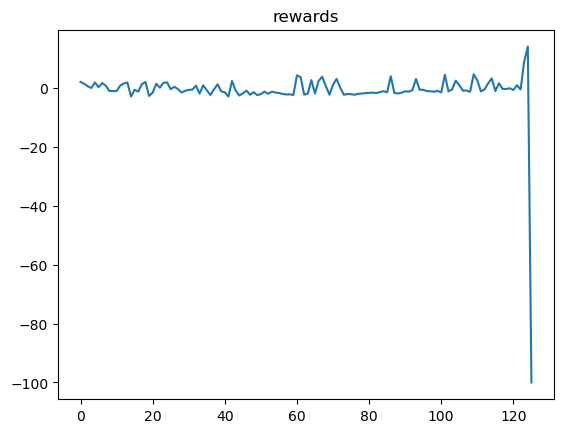

In [21]:
env = gym.make('LunarLander-v2')
obs, info = env.reset(seed = 42)
rewards = []

for t in range(1000):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)

    if terminated or truncated:
        print('terminated')
        print(obs)
        obs, info = env.reset()
        break
env.close()
sns.lineplot(y = rewards, x = list(range(len(rewards))))
plt.title("rewards")


# Replay Memory

In [22]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))
class ReplayMemory():
    def __init__(self, capacity = 50000) -> None:
        self.capacity = capacity
        self.memory = deque(maxlen = capacity)
    
    def push(self, state, action, reward, next_state):
        self.memory.append(Transition(state, action, reward, next_state))
    
    def sample(self, batch_size):
        if batch_size > len(self.memory): return None
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
    def clear(self):
        self.memory.clear()

In [23]:
#Test memory
memory = ReplayMemory(capacity=10)

for _ in range(10):
    state = random.randint(0,8)
    action = random.randint(0,3)
    reward = random.randint(-10, 10)
    next_state = random.randint(0,8)
    memory.push(state, action, reward, next_state)

batch = memory.sample(5)
print(batch)


[Transition(state=0, action=1, reward=-4, next_state=6), Transition(state=8, action=2, reward=10, next_state=7), Transition(state=6, action=1, reward=10, next_state=5), Transition(state=6, action=1, reward=-2, next_state=2), Transition(state=3, action=2, reward=10, next_state=2)]


# DQN network

In [24]:
class DQN(nn.Module):

    def __init__(self, n_observation, n_actions) -> None:
        super().__init__()
        self.layer1 = nn.Linear(n_observation, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)
    
    def forward(self, X):
        X = F.relu(self.layer1(X))
        X = F.relu(self.layer2(X))
        #we're not using activation function in here
        return self.layer3(X)
        

In [25]:
sample_state = torch.rand(8)
print(sample_state)
dqn = DQN(n_observation=8, n_actions=4)
sample_actions = dqn(sample_state).unsqueeze(0)
print(sample_actions)
print(sample_actions.max(1).indices.view(1,1))

tensor([0.1681, 0.2233, 0.0814, 0.0489, 0.5941, 0.1510, 0.6163, 0.6141])
tensor([[ 0.1493, -0.0295, -0.0051, -0.0216]], grad_fn=<UnsqueezeBackward0>)
tensor([[0]])


# Greedy epsilon 

In [26]:
def select_action(state, epsilon, env, policy_net, device):
    '''
    @params:
        state: np.array[int]
        epsilon: in
        env: Gym.Env
        policy_net: nn.Module
        device: str
    @returns:
        action: torch.tensor shape = (1,)
    '''
    prob = random.random()
    state = torch.tensor(state, dtype = torch.float32).to(device)
    #exploit
    if prob > epsilon: 
        return policy_net(state).max(1).indices.view(1)
    else:
        return torch.tensor([env.action_space.sample()], device = device, dtype = torch.long)

def calculate_epsilon(step, max_ep, min_ep, decay_ep):
    return min_ep + (max_ep - min_ep) * math.exp(-step * decay_ep)

def plot_epsilon_decay(min_ep, max_ep, decay_ep, training_eps):

    eps = []
    for t in range(training_eps):
        eps.append(calculate_epsilon(t, max_ep, min_ep, decay_ep))
    sns.lineplot(y = eps, x = list(range(len(eps))))

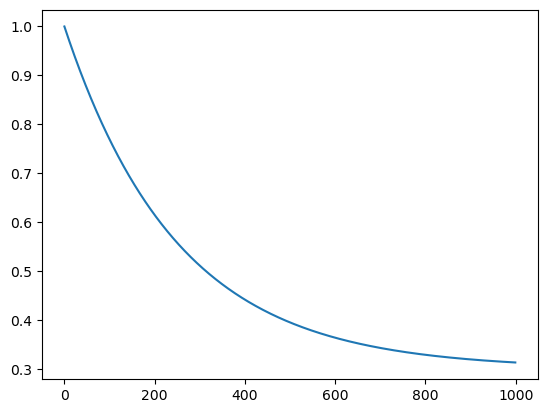

In [27]:
plot_epsilon_decay(0.3,1.0, 0.004, 1000)


In [28]:
# for t in range(10):
#     epsilon = calculate_epsilon(t, 0.99, 0.1, 10000)
#     print(epsilon)

# dqn = DQN(8, 4)
# print(select_action(torch.randint(0,4,(1,1)), epsilon, env, dqn, 'cpu'))

# Optimize model

In [29]:
a = map(lambda x: x + 1, [1,2,3,4,5,6])
print(a)

In [30]:
def optimize(memory, batch_size, policy_net, target_net, optimizer, criterion, device, grad_clip = 100, gamma = 0.99,  debug = False):

    #if batch < len(memory)
    if len(memory) < batch_size: return

    batch = memory.sample(batch_size)

    transitions = Transition(*zip(*batch))

    state_batch = torch.cat(transitions.state) 
    action_batch = torch.cat(transitions.action) 
    reward_batch = torch.cat(transitions.reward) 

    state_batch = state_batch.to(device)
    action_batch = action_batch.to(device)
    reward_batch = reward_batch.to(device)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # get the Q(s',a') from target_net
    non_final_next_states = torch.cat([s for s in transitions.next_state if s != None])
    non_final_next_states = non_final_next_states.to(device)
    target_net_output = target_net(non_final_next_states)

    expected_state_action_values = torch.zeros(batch_size, device = device)

    non_final_next_state_mask = torch.tensor(tuple(map(lambda s: s != None, transitions.next_state)), device = device)
    expected_state_action_values[non_final_next_state_mask] = target_net_output.max(1).values

    expected_state_action_values = reward_batch + (gamma * expected_state_action_values)

    #state action values shape = (batch_size, 1)
    #expected state action values shape = (batch_size, batch_size)
    #TODO: why batch size x batch_size ????

    optimizer.zero_grad()

    loss = criterion(state_action_values, expected_state_action_values)

    loss.backward()
    #clip grad to prevent exploding gradient
    nn.utils.clip_grad_value_(policy_net.parameters(), grad_clip)

    optimizer.step()

In [31]:
# memory
memory = ReplayMemory(capacity=10)

env = gym.make('LunarLander-v2', render_mode = 'human')
state, info = env.reset()

observation_n = len(state)
print('observation n = ', observation_n)
action_n = env.action_space.n
print('action n = ', action_n)

policy_net = DQN(observation_n, action_n)
target_net = DQN(observation_n, action_n)

for _ in range(20):
    state = torch.rand((1,observation_n))
    next_state = torch.rand((1,observation_n))
    reward = torch.randint(-10,10, (1,1))
    action = torch.randint(0,4, (1,1))

    memory.push(state, action, reward, next_state)

    state = next_state


optimizer = torch.optim.AdamW(policy_net.parameters(), lr = 0.001)
criterion = nn.SmoothL1Loss()

GAMMA = 0.9

optimize(memory, 5, policy_net=policy_net, target_net=target_net, optimizer=optimizer, criterion=criterion, gamma=GAMMA, device = 'cpu')
env.close()



observation n =  8
action n =  4


# Training loop

In [32]:
ROOT = os.getcwd()
OUTPUT = os.path.join(ROOT, 'output', 'lunar')
if os.path.exists(OUTPUT) == False:
    os.makedirs(OUTPUT)

In [34]:
def tune(
    gamma, batch_size, lr, 
    training_episodes, max_ep, min_ep, decay_ep, device,
    grad_clip = 10, target_net_update_freq = 10, tau = 0.005, 
    fig_update_freq = 50, save_fig_root = ROOT, name = ''): 
    #the TAU constant is for soft update when synchronize the policy and target net
    assert os.path.exists(OUTPUT), 'output to save model not found'

    env = gym.make('LunarLander-v2')

    memory = ReplayMemory(capacity=10)
    obs, info = env.reset()
    observation_n = len(obs)
    action_n = env.action_space.n

    print('observation n = ', observation_n)
    print('action n = ', action_n)

    policy_net = DQN(observation_n, action_n)
    target_net = DQN(observation_n, action_n)

    optimizer = torch.optim.AdamW(policy_net.parameters(), lr = 0.001)
    criterion = nn.SmoothL1Loss()

    policy_net.to(device)
    target_net.to(device)
    criterion.to(device)

    history = defaultdict(list)
    step = 0
    sync_count = 0

    loop = tqdm(range(training_episodes))
    best_reward = 0

    
    for episode in loop: 

        state, info = env.reset()
        state = torch.tensor(state, device = device, dtype = torch.float32).unsqueeze(0)
        total_reward = 0
        epsilon = calculate_epsilon(episode, max_ep, min_ep, decay_ep)

        for t in count():
            step += 1
            action = select_action(state, epsilon, env, policy_net, device)
            next_state, reward, terminated, truncated, info = env.step(action.item())
            done = terminated or truncated

            total_reward += reward

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(next_state, device = device, dtype = torch.float32).unsqueeze(0)
            
            reward = torch.tensor(reward).unsqueeze(0)
            action = action.unsqueeze(0)
            
            memory.push(state, action, reward, next_state)

            state = next_state

            optimize(memory, batch_size, policy_net, target_net,optimizer, criterion, gamma = gamma, device = device, grad_clip=grad_clip)

            #soft update target net every C step
            #link: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
            if step % target_net_update_freq == 0:
                sync_count += 1
                policy_net_state_dict = policy_net.state_dict()
                target_net_state_dict = target_net.state_dict()

                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key] * tau + target_net_state_dict[key] * (1 - tau)
                
                target_net.load_state_dict(target_net_state_dict)
            loop.set_description(f'epoch = {episode}, epsilon = {epsilon:.3f}, total reward = {total_reward:.3f}, sync count = {sync_count}')
            
            if done: 
                break

        history['epsilon'].append(epsilon)
        history['reward'].append(total_reward)

        if best_reward < total_reward:
            torch.save(policy_net, os.path.join(OUTPUT, 'policy_net.checkpoint.torch'))
            torch.save(target_net, os.path.join(OUTPUT, 'target_net.checkpoint.torch'))

        if episode % fig_update_freq == 0:
            filename = os.path.join(save_fig_root, f'{name}_lunar_lander.gamma={gamma},batch_size={batch_size},lr={lr},decay_ep={decay_ep}.png')
            plot(history, filename)
    #close training loop
    plot(history, show = True)
    env.close()
    return history

def plot(history, savepath = None, show = False):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
    sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))), ax = ax1, color='red')
    ax1.set_title("Reward per episodes")
    sns.lineplot(y = history['epsilon'], x = list(range(len(history['epsilon']))), ax = ax2)
    ax2.set_title("Epsilone decay")
    if savepath:
        plt.savefig(savepath)
    if show:
        plt.show()
    plt.close()

# Exp 1

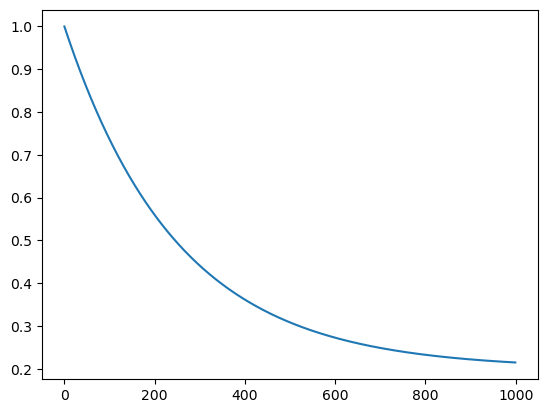

In [78]:
plot_epsilon_decay(0.2,1.0, 0.004, 1000)

observation n =  8
action n =  4


epoch = 999, epsilon = 0.215, total reward = -264.522, sync count = 19515: 100%|██████████| 1000/1000 [27:57<00:00,  1.68s/it]


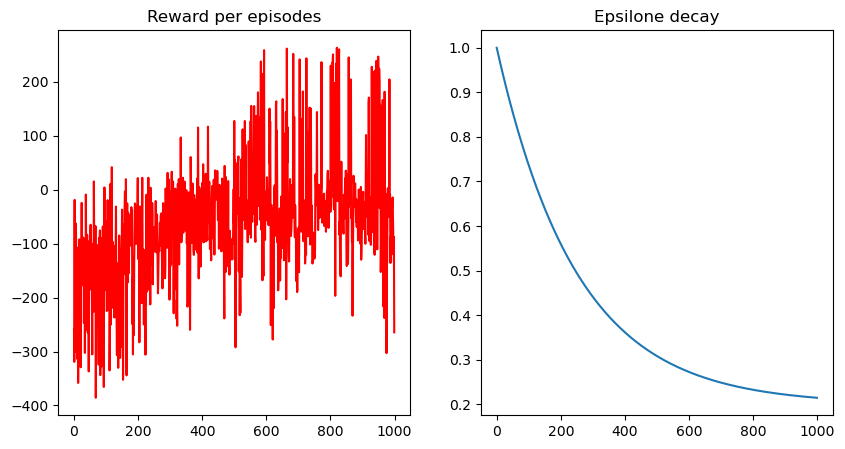

In [79]:
GAMMA = 0.9
BATCH_SIZE = 10 
LR = 0.001
MAX_EPSILON = 1.0
MIN_EPSILON = 0.2
DECAY_EPSILON = 0.004
TRAINING_EPISODES = 1000
TARGETNET_UPDATE_FREQ = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

history = tune(
    gamma=GAMMA,
    batch_size=BATCH_SIZE,
    lr=LR,
    training_episodes=TRAINING_EPISODES, 
    max_ep=MAX_EPSILON, 
    min_ep=MIN_EPSILON, 
    decay_ep=DECAY_EPSILON, 
    target_net_update_freq=TARGETNET_UPDATE_FREQ, 
    device=DEVICE,
    fig_update_freq=50)


In [ ]:
# Run the final mdel
env = gym.make('LunarLander-v2', render_mode = 'human')

def run_final_model(policy_net, env, device, debug = False):
    state, info = env.reset()
    state = torch.tensor(state).to(device).unsqueeze(0)
    total_reward = 0

    for t in count():
        action = select_action(state, 0, env, policy_net, device)
        next_state, reward, terminated, truncated, info = env.step(action.item())

        total_reward += reward
        if terminated or truncated:
            if debug:
                print('exit')
                print('reward = ', total_reward)
                print(info)
            return total_reward

        next_state = torch.tensor(next_state).to(device).unsqueeze(0)
        state = next_state

SAVED_POLICY = os.path.join(ROOT, 'output', 'lunar', 'policy_net.checkpoint.torch')
best_policy_net = torch.load(SAVED_POLICY)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

rewards = []
loop =  tqdm(range(10))
for trial in loop:
    reward = run_final_model(best_policy_net, env, device)
    rewards.append(reward)
    loop.set_description(f'trial ={trial}, reward = {reward}')

sns.lineplot(y = rewards, x = list(range(len(rewards))))
plt.title('final agent reward graph')
plt.show()
env.close()


# Exp 2

observation n =  8
action n =  4


epoch = 0, epsilon = 1.000, total reward = 1.375, sync count = 0:   0%|          | 0/2000 [00:00<?, ?it/s] 

epoch = 1999, epsilon = 0.240, total reward = -18.363, sync count = 26247: 100%|██████████| 2000/2000 [34:27<00:00,  1.03s/it] 


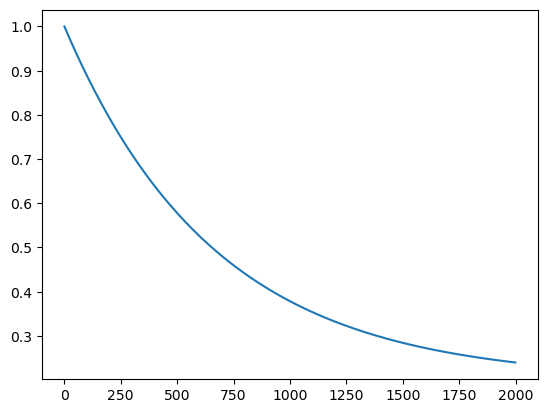

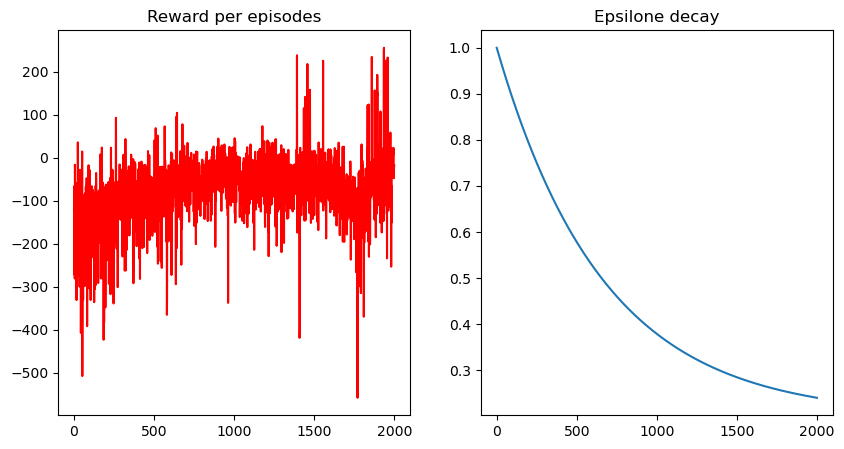

In [143]:
GAMMA = 0.9
BATCH_SIZE = 10 
LR = 0.001
MIN_EPSILON = 0.2
MAX_EPSILON = 1.0
DECAY_EPSILON = 0.0015
TRAINING_EPISODES = 2000
TARGETNET_UPDATE_FREQ = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

plot_epsilon_decay(MIN_EPSILON,MAX_EPSILON, DECAY_EPSILON, TRAINING_EPISODES)

history = tune(
    gamma=GAMMA,
    batch_size=BATCH_SIZE,
    lr=LR,
    training_episodes=TRAINING_EPISODES, 
    max_ep=MAX_EPSILON, 
    min_ep=MIN_EPSILON, 
    decay_ep=DECAY_EPSILON, 
    target_net_update_freq=TARGETNET_UPDATE_FREQ, 
    device=DEVICE,
    fig_update_freq=50)

# Exp 3

observation n =  8
action n =  4


epoch = 2999, epsilon = 0.246, total reward = -60.504, sync count = 50147: 100%|██████████| 3000/3000 [1:10:16<00:00,  1.41s/it] 


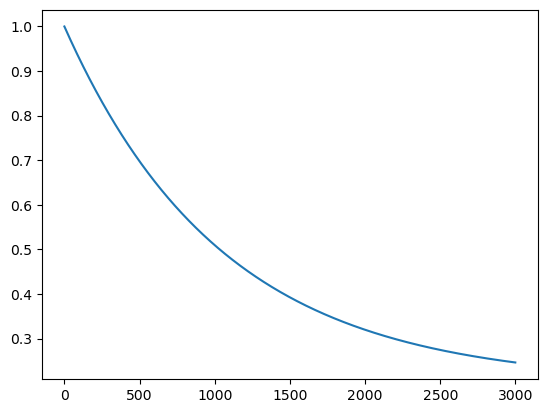

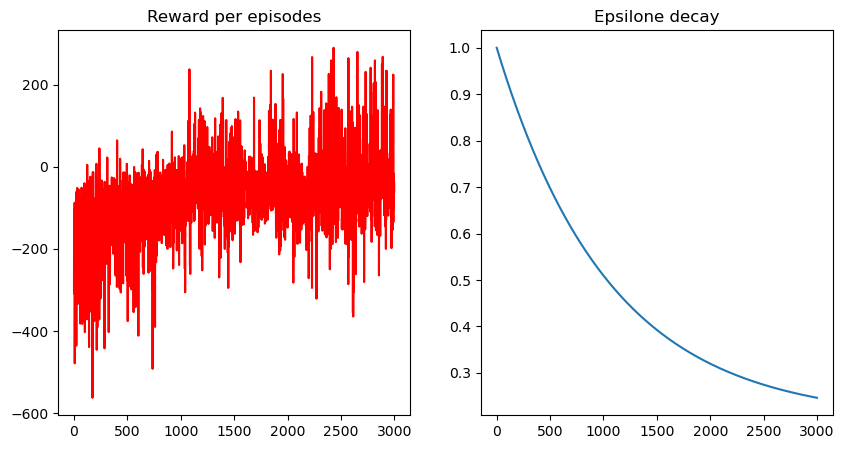

In [144]:
GAMMA = 0.9
BATCH_SIZE = 10 
LR = 0.001
MAX_EPSILON = 1.0
MIN_EPSILON = 0.2
DECAY_EPSILON = 0.00095

TRAINING_EPISODES = 3000
TARGETNET_UPDATE_FREQ = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

plot_epsilon_decay(MIN_EPSILON,MAX_EPSILON, DECAY_EPSILON,TRAINING_EPISODES)

history = tune(
    gamma=GAMMA,
    batch_size=BATCH_SIZE,
    lr=LR,
    training_episodes=TRAINING_EPISODES, 
    max_ep=MAX_EPSILON, 
    min_ep=MIN_EPSILON, 
    decay_ep=DECAY_EPSILON, 
    target_net_update_freq=TARGETNET_UPDATE_FREQ, 
    device=DEVICE,
    fig_update_freq=50)

# Exp 4, batch size to 5

observation n =  8
action n =  4


epoch = 2999, epsilon = 0.314, total reward = -39.597, sync count = 73039: 100%|██████████| 3000/3000 [1:42:52<00:00,  2.06s/it]   


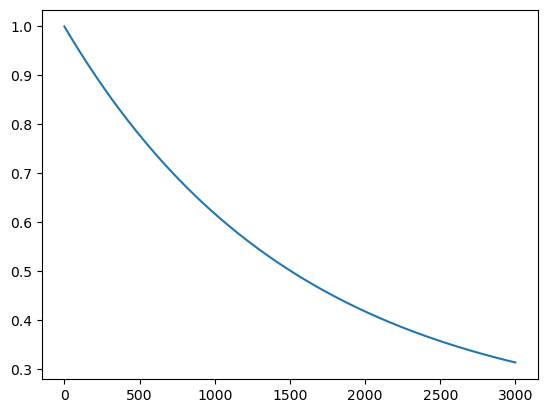

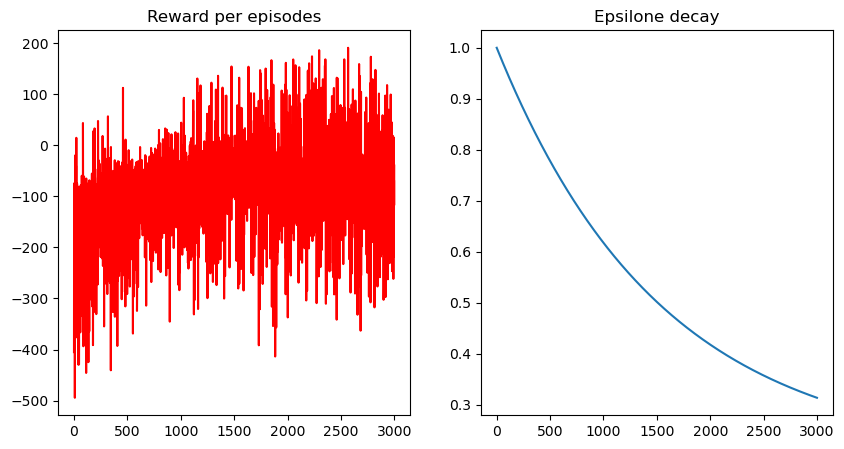

In [145]:
GAMMA = 0.9
BATCH_SIZE = 5 
LR = 0.001
MAX_EPSILON = 1.0
MIN_EPSILON = 0.2
DECAY_EPSILON = 0.00065

TRAINING_EPISODES = 3000
TARGETNET_UPDATE_FREQ = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

plot_epsilon_decay(MIN_EPSILON,MAX_EPSILON, DECAY_EPSILON,TRAINING_EPISODES)

history = tune(
    gamma=GAMMA,
    batch_size=BATCH_SIZE,
    lr=LR,
    training_episodes=TRAINING_EPISODES, 
    max_ep=MAX_EPSILON, 
    min_ep=MIN_EPSILON, 
    decay_ep=DECAY_EPSILON, 
    target_net_update_freq=TARGETNET_UPDATE_FREQ, 
    device=DEVICE,
    fig_update_freq=50)
 

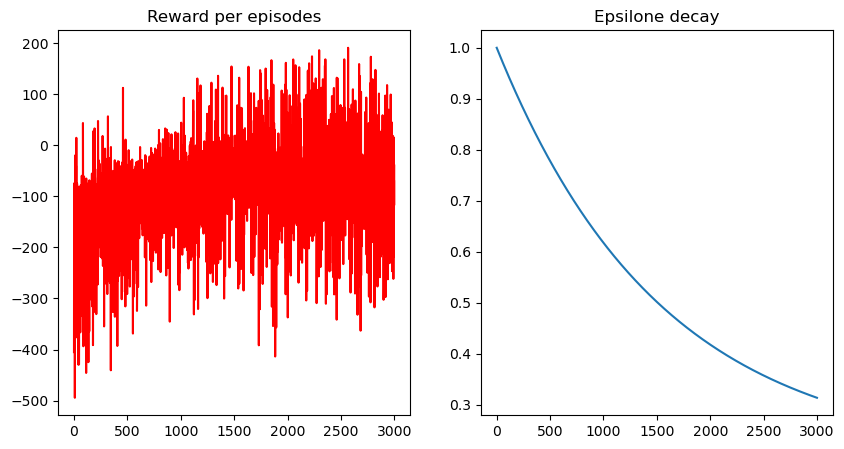

In [158]:
def plot(history, savepath = None, show = False):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
    sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))), ax = ax1, color='red')
    ax1.set_title("Reward per episodes")
    sns.lineplot(y = history['epsilon'], x = list(range(len(history['epsilon']))), ax = ax2)
    ax2.set_title("Epsilone decay")
    if savepath:
        plt.savefig(savepath)
    if show:
        plt.show()
    plt.close()


plot(history, show = True)

# Exp 5, change gamma to 0.5

epoch = 2999, epsilon = 0.314, total reward = 40.989, sync count = 73195: 100%|██████████| 3000/3000 [1:31:15<00:00,  1.83s/it]  


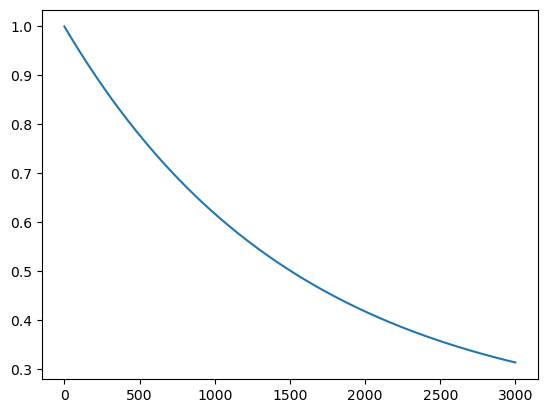

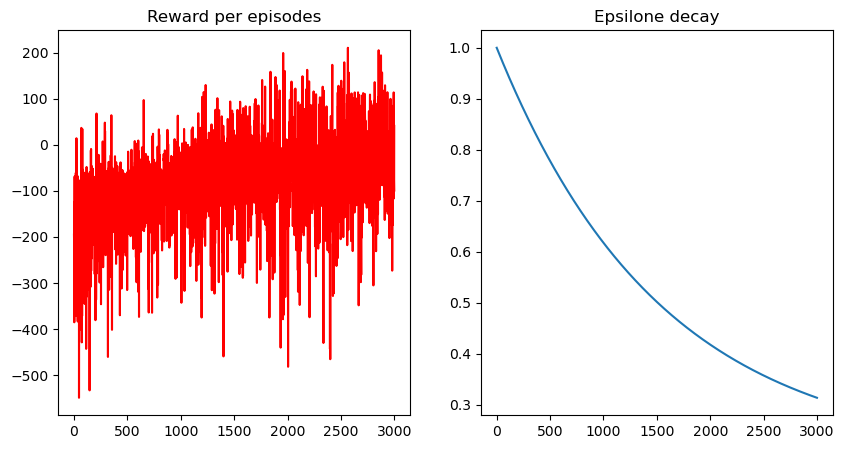

In [159]:
GAMMA = 0.5
BATCH_SIZE = 10
LR = 0.001
MAX_EPSILON = 1.0
MIN_EPSILON = 0.2
DECAY_EPSILON = 0.00065

TRAINING_EPISODES = 3000
TARGETNET_UPDATE_FREQ = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

plot_epsilon_decay(MIN_EPSILON,MAX_EPSILON, DECAY_EPSILON,TRAINING_EPISODES)

history = tune(
    gamma=GAMMA,
    batch_size=BATCH_SIZE,
    lr=LR,
    training_episodes=TRAINING_EPISODES, 
    max_ep=MAX_EPSILON, 
    min_ep=MIN_EPSILON, 
    decay_ep=DECAY_EPSILON, 
    target_net_update_freq=TARGETNET_UPDATE_FREQ, 
    device=DEVICE,
    fig_update_freq=50)
 

# Exp 6

observation n =  8
action n =  4


epoch = 2999, epsilon = 0.314, total reward = -215.754, sync count = 46171: 100%|██████████| 3000/3000 [07:18<00:00,  6.84it/s] 


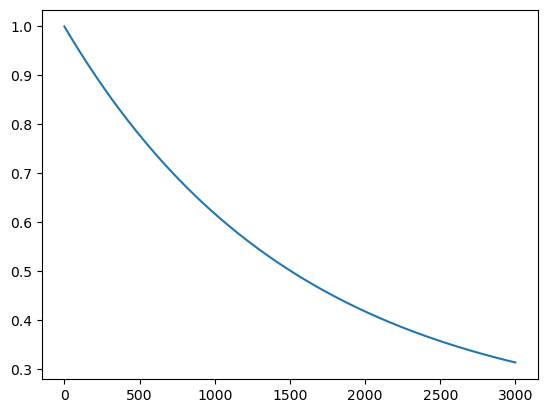

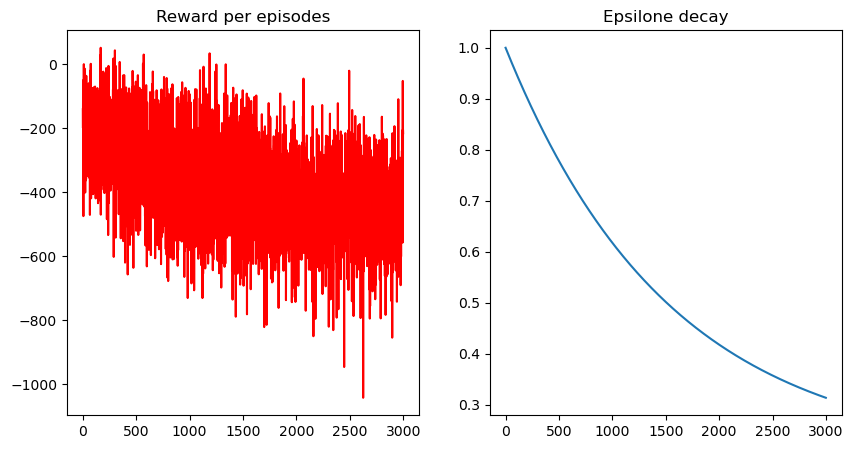

In [35]:
GAMMA = 0.99
BATCH_SIZE = 15
LR = 0.001
MAX_EPSILON = 1.0
MIN_EPSILON = 0.2
DECAY_EPSILON = 0.00065

TRAINING_EPISODES = 3000
TARGETNET_UPDATE_FREQ = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

plot_epsilon_decay(MIN_EPSILON,MAX_EPSILON, DECAY_EPSILON,TRAINING_EPISODES)

history = tune(
    gamma=GAMMA,
    batch_size=BATCH_SIZE,
    lr=LR,
    training_episodes=TRAINING_EPISODES, 
    max_ep=MAX_EPSILON, 
    min_ep=MIN_EPSILON, 
    decay_ep=DECAY_EPSILON, 
    target_net_update_freq=TARGETNET_UPDATE_FREQ, 
    device=DEVICE,
    name = 'exp6',
    fig_update_freq=50)

# Exp 7, training ep = 5000

observation n =  8
action n =  4


epoch = 4999, epsilon = 0.284, total reward = -290.223, sync count = 215296: 100%|██████████| 5000/5000 [2:32:23<00:00,  1.83s/it]  


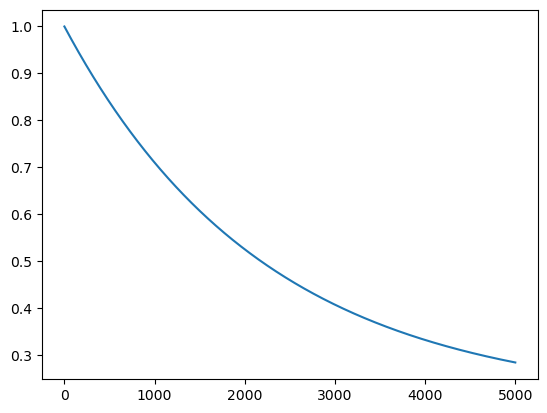

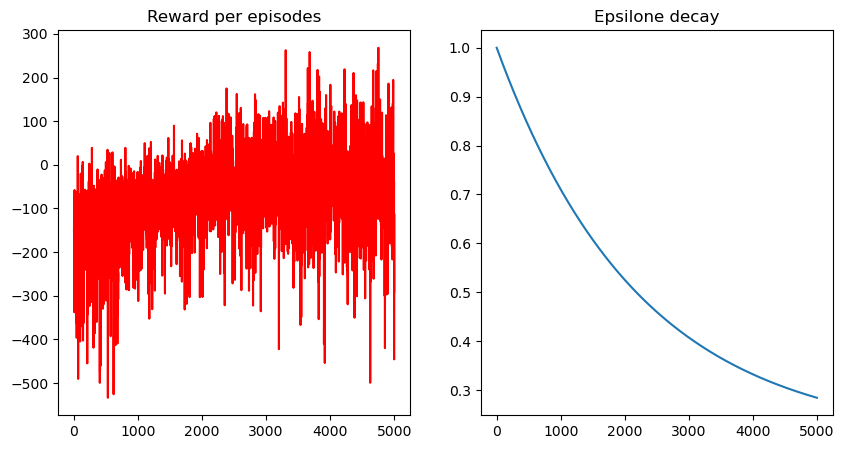

In [60]:
GAMMA = 0.99
BATCH_SIZE = 10
LR = 0.001
MAX_EPSILON = 1.0
MIN_EPSILON = 0.2
DECAY_EPSILON = 0.00045

TRAINING_EPISODES = 1000
TARGETNET_UPDATE_FREQ = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

plot_epsilon_decay(MIN_EPSILON,MAX_EPSILON, DECAY_EPSILON,TRAINING_EPISODES)

history = tune(
    gamma=GAMMA,
    batch_size=BATCH_SIZE,
    lr=LR,
    training_episodes=TRAINING_EPISODES, 
    max_ep=MAX_EPSILON, 
    min_ep=MIN_EPSILON, 
    decay_ep=DECAY_EPSILON, 
    target_net_update_freq=TARGETNET_UPDATE_FREQ, 
    device=DEVICE,
    name = 'exp7',
    fig_update_freq=50)

trial =9, reward = -128.49043526714917: 100%|██████████| 10/10 [01:22<00:00,  8.23s/it]


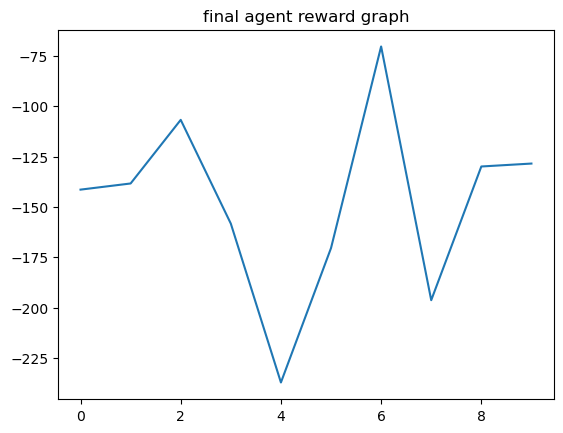

In [61]:
# Run the final mdel
env = gym.make('LunarLander-v2', render_mode = 'human')

def run_final_model(policy_net, env, device, debug = False):
    state, info = env.reset()
    state = torch.tensor(state).to(device).unsqueeze(0)
    total_reward = 0

    for t in count():
        action = select_action(state, 0, env, policy_net, device)
        next_state, reward, terminated, truncated, info = env.step(action.item())

        total_reward += reward
        if terminated or truncated:
            if debug:
                print('exit')
                print('reward = ', total_reward)
                print(info)
            return total_reward

        next_state = torch.tensor(next_state).to(device).unsqueeze(0)
        state = next_state

SAVED_POLICY = os.path.join(ROOT, 'output', 'lunar', 'policy_net.checkpoint.torch')
best_policy_net = torch.load(SAVED_POLICY)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

rewards = []
loop =  tqdm(range(10))
for trial in loop:
    reward = run_final_model(best_policy_net, env, device)
    rewards.append(reward)
    loop.set_description(f'trial ={trial}, reward = {reward}')

sns.lineplot(y = rewards, x = list(range(len(rewards))))
plt.title('final agent reward graph')
plt.show()
env.close()